In [22]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import folium

import osmnx as ox
import networkx as nx

import sys, os

%matplotlib inline

In [2]:
PROJECT_PATH = "/Users/frankkelly/Dropbox/Projects-new/bristol_emissions/"
config_path = os.path.join(PROJECT_PATH, "src", "conf")

In [25]:
loop_df = pd.read_csv(os.path.join(PROJECT_PATH, "data", "raw", "guildford_loop_1 - guildford_loop_1.csv.csv"))
loop_df_sampled = loop_df.sample(250).sort_values(by="Time Stamp [s]")

In [26]:
loop_df.head()

Time Stamp [s]    NO [ppm]  Calculated engine load [%]  \
0         445.300  137.356792                         0.0   
1         445.310  138.305559                         0.0   
2         445.320  138.146337                         0.0   
3         445.335  139.587544                         0.0   
4         445.340  139.587544                         0.0   

   Intake manifold absolute pressure [kPa]  Engine Speed [RPM]  \
0                                    113.0             2002.75   
1                                    113.0             2002.75   
2                                    113.0             2002.75   
3                                    108.0             2002.75   
4                                    108.0             2002.75   

   Vehicle speed [km/h]  MAF air flow rate [g/s]  GPS Time stamp   Latitude  \
0                  49.0                    40.59         39301.6  51.239646   
1                  49.0                    40.59         39301.6  51.239646   
2                  49.0                    40.59         39301.6  51.239646   
3                  49.0                    40.59         39301.6  51.239646   
4                  49.0                    40.59         39301.6  51.239646   

   Longitude  GPS-Quality  Satellites  HDop  Altitude [m]  GPS Speed [km/h]  \
0  -0.575852          5.0        13.0     1        41.337           50.0966   
1  -0.575852          5.0        13.0     1        41.295           50.0966   
2  -0.575852          5.0        13.0     1        41.295           50.0966   
3  -0.575852          5.0        13.0     1        41.295           50.0966   
4  -0.575852          5.0        13.0     1        41.295           50.0966   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [27]:
graph_dir = os.path.join(PROJECT_PATH, "graphs")
place = "Guildford, UK"
# Load graph
guildford = nx.read_gpickle(os.path.join(graph_dir, "graph_guildford_with_elevation.gpkl"))

# Calculate some summary stats
Use an undirected representation of the network so we don't overcount two-way streets (because they have reciprocal edges pointing in each direction). We use the absolute value of edge grade because we're interested in steepness, not directionality.

In [28]:

edge_grades = [data['grade_abs'] for u, v, k, data in ox.get_undirected(guildford).edges(keys=True, data=True)]

In [29]:


avg_grade = np.mean(edge_grades)
print('Average street grade in {} is {:.1f}%'.format(place, avg_grade*100))

med_grade = np.median(edge_grades)
print('Median street grade in {} is {:.1f}%'.format(place, med_grade*100))

Average street grade in Guildford, UK is 3.0%
Median street grade in Guildford, UK is 2.0%


Let's plot the nodes by elevation; colored from low (violet) to high (yellow).

In [30]:

# project the street network to UTM
guildford_projected = ox.project_graph(guildford)

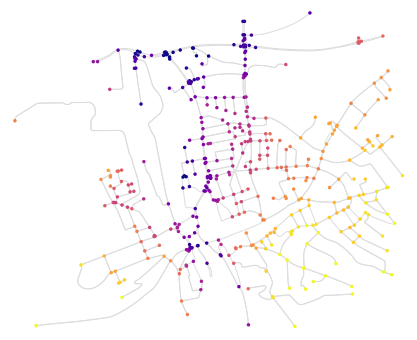

In [31]:

# get one color for each node, by elevation, then plot the network
nc = ox.get_node_colors_by_attr(guildford_projected, 'elevation', cmap='plasma', num_bins=20)
fig, ax = ox.plot_graph(guildford_projected, fig_height=6, node_color=nc, node_size=12, node_zorder=2, edge_color='#dddddd')


## Plot the edges by grade
Grade is the ratio of elevation change to edge length. Plot edges colored from low/flat (violet) to high/steep (yellow).

In [32]:
# get a color for each edge, by grade, then plot the network
ec = ox.get_edge_colors_by_attr(guildford_projected, 'grade_abs', cmap='plasma', num_bins=100)
fig, ax = ox.plot_graph(guildford_projected, fig_height=6, edge_color=ec, edge_linewidth=0.8, node_size=0)

In [33]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [34]:
geometry_lat_long = [Point(xy) for xy in zip(loop_df_sampled.Longitude, loop_df_sampled.Latitude)]

crs_latlong = {'init': 'epsg:4326'}

loop_gdf = GeoDataFrame(loop_df_sampled, crs=crs_latlong, geometry=geometry_lat_long)

loop_gdf.head()

Time Stamp [s]    NO [ppm]  Calculated engine load [%]  \
170          446.990  221.964487                   41.960784   
1920         464.520   78.449541                   61.960784   
2063         465.990   84.219290                   61.960784   
2448         469.850   46.936704                   58.823529   
3564         481.055   46.145518                   43.921569   

      Intake manifold absolute pressure [kPa]  Engine Speed [RPM]  \
170                                      99.0             1498.00   
1920                                     81.0             1310.00   
2063                                     80.0             1321.25   
2448                                     78.0             1337.25   
3564                                     76.0             1360.75   

      Vehicle speed [km/h]  MAF air flow rate [g/s]  GPS Time stamp  \
170                   51.0                    24.93         39303.2   
1920                  44.0                    18.68         39320.8   
2063                  45.0                    16.50         39322.2   
2448                  45.0                    15.65         39326.0   
3564                  46.0                    15.46         39337.2   

       Latitude  Longitude  GPS-Quality  Satellites  HDop  Altitude [m]  \
170   51.239845  -0.575888          4.5        12.0     1       40.9290   
1920  51.241941  -0.576210          5.0        12.5     1       40.2155   
2063  51.242103  -0.576198          5.0        10.5     1       40.2680   
2448  51.242545  -0.576189          5.0        10.0     1       40.2730   
3564  51.243831  -0.576451          5.0        12.0     1       38.5330   

      GPS Speed [km/h]  Comments                                 geometry  
170           51.59672       NaN         POINT (-0.5758881782 51.2398453)  
1920          46.05924       NaN   POINT (-0.576209935 51.24194050000001)  
2063          45.91108       NaN  POINT (-0.5761981186999999 51.24210336)  
2448          47.20748       NaN        POINT (-0.5761889983 51.24254498)  
3564          46.83708       NaN  POINT (-0.5764506632999999 51.24383142)

In [35]:
loop_gdf['Longitude'].isna().sum()

0

In [36]:
# Drop the locations without location values
print(loop_gdf.shape)
loop_clean_gdf = loop_gdf[(~loop_gdf['Longitude'].isnull()) 
                             & ~loop_gdf['Latitude'].isnull()].copy()
print(loop_clean_gdf.shape)

(250, 17)
(250, 17)


In [37]:
gjson = loop_gdf.to_crs(epsg='4326').to_json()


Plot all observation points onto the map to see where we have decent coverage

In [38]:
def plot_gdf_folium(df, gjson, zoom=6):
    """
    Plot a folium map of a dataframe
    Parameters
    ----------
    gdf: pandas dataframe
        Must have columns 'lat' and 'long' containing latitude and longitude respectively
    zoom: int
        zoom_start of the folium map
    Returns
    -------
    folium map
        Map of row locations
    """
    df = df.sample(25).copy()
    centre_lat = (df['Latitude'].max()+df['Latitude'].min())/2
    centre_lng = (df['Longitude'].max()+df['Longitude'].min())/2

    mapa = folium.Map(width=400,height=500,location=[centre_lat, centre_lng], 
                      zoom_start = zoom)
    
    points = folium.features.GeoJson(gjson)
    mapa.add_children(points)

#     for _,row in df.iterrows():
#             folium.CircleMarker(location=(row['lat'], row['long']), fill=True,
#                                 radius=2).add_to(mapa)

    return mapa

# plot_df_folium(waterlevelDF)
plot_gdf_folium(loop_gdf, gjson, 14)

/Users/frankkelly/.virtualenvs/bristol-emissions-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


Let's go through the sampled_df and find the points closest to each graph node

In [35]:
nodes = []
for index, row in loop_df_sampled.iterrows():
    nearest_node = ox.get_nearest_node(guildford, (row['Latitude'], 
                                                   row['Longitude']))
    nodes.append(nearest_node)
loop_df_sampled['Node'] = nodes

In [36]:
loop_df_sampled.head()

Time Stamp [s]    NO [ppm]  Calculated engine load [%]  \
54        445.82000  103.615932                   68.627451   
252       447.80595  215.073614                   15.686275   
358       448.87000   34.409048                    0.000000   
491       450.18000   16.436655                    0.000000   
511       450.40000   16.594236                    0.784314   

     Intake manifold absolute pressure [kPa]  Engine Speed [RPM]  \
54                                      96.0             1451.25   
252                                     83.0             1492.50   
358                                     75.0             1466.75   
491                                     74.0             1419.25   
511                                     74.0             1418.25   

     Vehicle speed [km/h]  MAF air flow rate [g/s]  GPS Time stamp   Latitude  \
54                   49.0                    28.00         39302.0  51.239699   
252                  51.0                    19.25         39304.0  51.239952   
358                  50.0                    25.78         39305.0  51.240086   
491                  48.0                    24.65         39306.4  51.240249   
511                  48.0                    24.87         39306.6  51.240272   

     Longitude  GPS-Quality  Satellites  HDop  Altitude [m]  GPS Speed [km/h]  \
54   -0.575859          5.0        13.0     1       41.2530          49.74472   
252  -0.575910          4.0        12.0     1       40.7555          51.93008   
358  -0.575939          4.0        13.0     1       40.6640          50.46700   
491  -0.575974          4.0        14.0     1       40.5700          48.94836   
511  -0.575979          4.0        14.0     1       40.5650          48.91132   

     Comments                                 geometry      Node  
54        NaN  POINT (-0.5758594136999999 51.23969861)  30022986  
252       NaN    POINT (-0.5759099732999999 51.239952)  30022986  
358       NaN         POINT (-0.575938759 51.24008558)  30023002  
491       NaN         POINT (-0.5759741168 51.2402488)  30023002  
511       NaN        POINT (-0.5759790698 51.24027222)  30023002

That's the closest node in each case, however doesn't really give us which road the data is from. 
Furthermore, as OSMNx doesn't have a "closest edge" function, we have to write our own using this data type: 
shapely.geometry.LineString

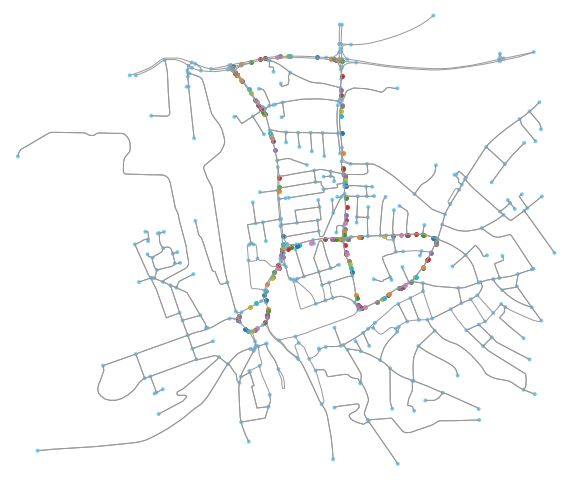

In [55]:
fig, ax = ox.plot_graph(guildford, show=False, close=False, fig_height=10, fig_width=10)
for index, row in loop_df_sampled.iterrows():
    
    ax.scatter(row["Longitude"], row["Latitude"], s=15, cmap=row["NO [ppm]"])
plt.show()

In [62]:
list(guildford.edges([30022986, 30022988], data=True))

[(30022986,
  30022988,
  {'osmid': 4715520,
   'name': 'Church Road',
   'highway': 'residential',
   'oneway': False,
   'length': 176.87099999999998,
   'geometry': <shapely.geometry.linestring.LineString at 0x124b62b70>,
   'grade': 0.0221,
   'grade_abs': 0.0221}),
 (30022988,
  30022991,
  {'osmid': 8151835,
   'name': 'Artillery Terrace',
   'highway': 'residential',
   'oneway': False,
   'length': 55.873,
   'grade': -0.0032,
   'grade_abs': 0.0032}),
 (30022988,
  30022986,
  {'osmid': 4715520,
   'name': 'Church Road',
   'highway': 'residential',
   'oneway': False,
   'length': 176.87099999999998,
   'geometry': <shapely.geometry.linestring.LineString at 0x124b62ba8>,
   'grade': -0.0221,
   'grade_abs': 0.0221}),
 (30022988,
  27070450,
  {'osmid': [4418776, 4717738, 8151835],
   'name': ['Stoke Fields', 'Artillery Terrace'],
   'highway': ['unclassified', 'residential'],
   'oneway': False,
   'length': 175.61,
   'geometry': <shapely.geometry.linestring.LineString at 0x